# Question 1

 The reason the Ordinary Least Squares (OLS) fitted line is not aligned with the majority of the data points is the presence of outliers.

# Question 2

In [5]:
# Listing 1: Load and preprocess data
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the penguins dataset
df = sns.load_dataset("penguins")
df.dropna(inplace=True)

# Filter for 'Adelie' and 'Chinstrap' classes
selected_classes = ['Adelie', 'Chinstrap']
df_filtered = df[df['species'].isin(selected_classes)].copy()

# Encode the species column
le = LabelEncoder()
df_filtered['class_encoded'] = le.fit_transform(df_filtered['species'])
print(df_filtered[['species', 'class_encoded']].head())

# Split features and target
y = df_filtered['class_encoded']
# Build X from numeric columns only and make sure to exclude target safely
num_cols = df_filtered.select_dtypes(include=[np.number]).columns.tolist()
if 'class_encoded' in num_cols:
    num_cols.remove('class_encoded')
X = df_filtered[num_cols]

# Listing 2: Train Logistic Regression with saga solver
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(solver='saga', max_iter=1000)
try:
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Coefficients:", logreg.coef_, "Intercept:", logreg.intercept_)
except Exception as e:
    print("Error during training:", e)

  species  class_encoded
0  Adelie              0
1  Adelie              0
2  Adelie              0
4  Adelie              0
5  Adelie              0
Accuracy: 0.5813953488372093
Coefficients: [[ 0.02591916 -0.0010713   0.00115442 -0.00057873]] Intercept: [-0.00010196]


c:\Users\HP\anaconda3\envs\Vision\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Liblinear Solver Accuracy: 1.0
Saga Solver with Scaling Accuracy: 0.9767441860465116
Liblinear Solver with Scaling Accuracy: 0.9767441860465116


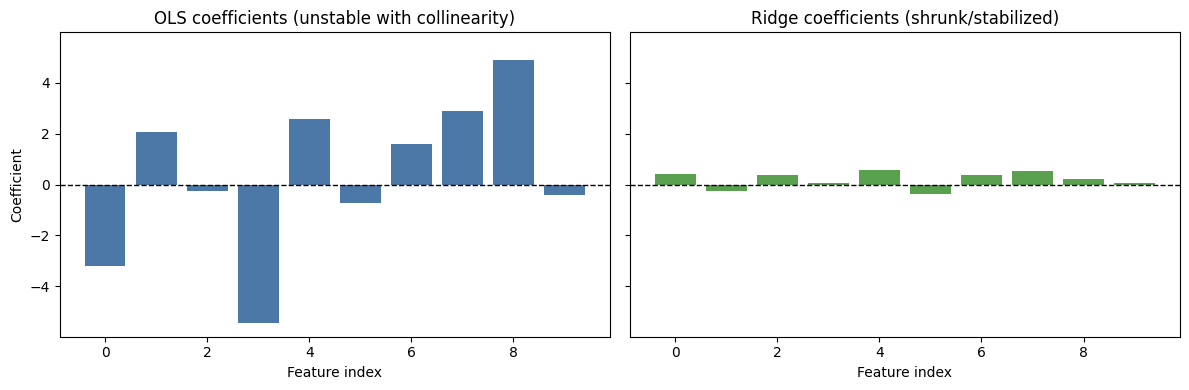

Test MSE - OLS: 0.24883871062999868
Test MSE - Ridge (alpha=1): 0.24323272208382815


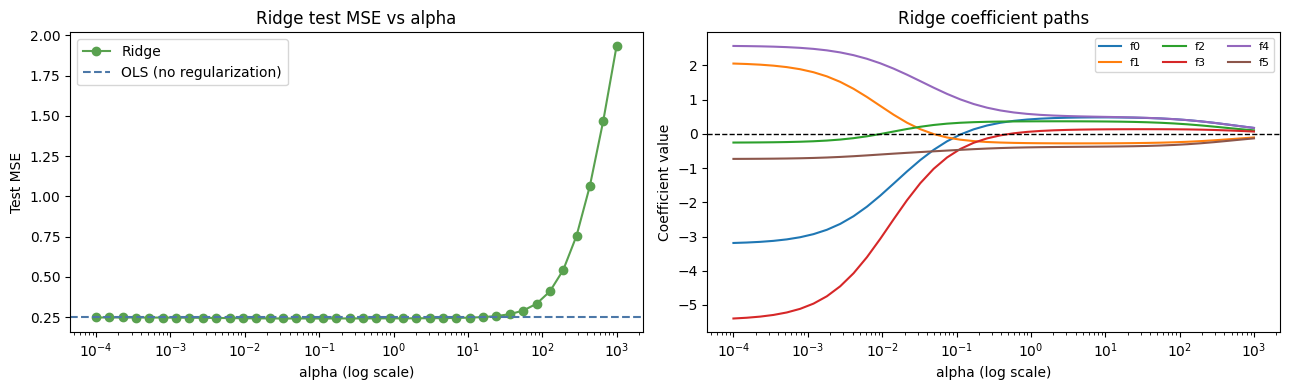

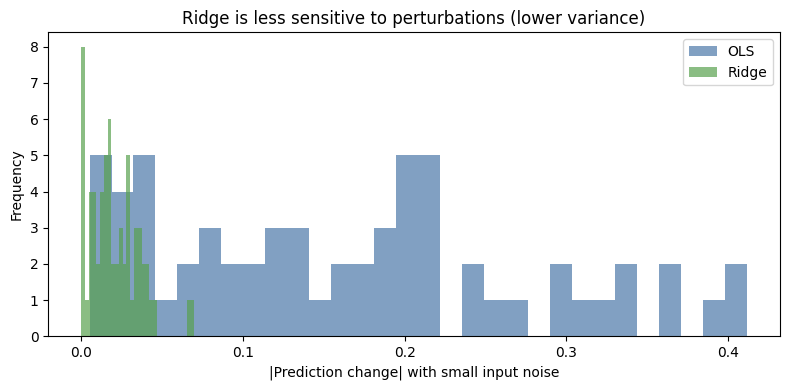

Median |Δy| OLS: 0.15821633071031904
Median |Δy| Ridge: 0.017906504643247945


In [6]:

# 2. Error resolution
# The saga solver may require feature scaling or adjusting max_iter. If there was an error, increase max_iter or switch solvers.

# 3. Why saga solver performs poorly?
# The saga solver uses stochastic optimization which can be slow to converge on unscaled features and small datasets.

# 4. Change solver to liblinear
logreg_lib = LogisticRegression(solver='liblinear')
logreg_lib.fit(X_train, y_train)
y_pred_lib = logreg_lib.predict(X_test)
acc_lib = accuracy_score(y_test, y_pred_lib)
print("Liblinear Solver Accuracy:", acc_lib)

# 7. Feature scaling impact
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
logreg_saga_scaled = LogisticRegression(solver='saga', max_iter=1000)
logreg_saga_scaled.fit(X_train_s, y_train_s)
acc_saga_scaled = accuracy_score(y_test_s, logreg_saga_scaled.predict(X_test_s))
print("Saga Solver with Scaling Accuracy:", acc_saga_scaled)
print("Liblinear Solver with Scaling Accuracy:", accuracy_score(y_test_s, LogisticRegression(solver='liblinear').fit(X_train_s, y_train_s).predict(X_test_s)))

# Make a strongly collinear dataset (new cell)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

np.random.seed(123)
n_samples = 250
# Start with 4 independent base features
Z = np.random.randn(n_samples, 4)

# Create 6 highly collinear features from the base ones
noise = 0.02 * np.random.randn(n_samples, 6)
Xc = np.c_[
    Z,
    Z[:, 0] + noise[:, 0],                  # near-duplicate of f0
    0.8*Z[:, 1] - 0.2*Z[:, 2] + noise[:, 1],
    Z[:, 2] + Z[:, 3] + noise[:, 2],
    Z[:, 0] - Z[:, 1] + noise[:, 3],
    1.5*Z[:, 3] + noise[:, 4],
    Z[:, 1] + Z[:, 2] + noise[:, 5],
]
feature_names = [f"f{i}" for i in range(Xc.shape[1])]

# True relationship depends on base features (others are redundant/collinear)
beta = np.array([1.5, -1.0, 0.8, 0.5])  # for Z columns
y = Z @ beta + 0.5 * np.random.randn(n_samples)

# Scale and split
scaler_c = StandardScaler()
Xc_scaled = scaler_c.fit_transform(Xc)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc_scaled, y, test_size=0.25, random_state=42)

# OLS vs Ridge coefficients side-by-side, same y-scale (new cell)
ols_c = LinearRegression().fit(Xc_train, yc_train)
ridge_c = Ridge(alpha=1.0, random_state=42).fit(Xc_train, yc_train)

coef_ols = ols_c.coef_
coef_ridge = ridge_c.coef_
ylim = 1.1 * max(np.max(np.abs(coef_ols)), np.max(np.abs(coef_ridge)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].bar(range(len(coef_ols)), coef_ols, color="#4C78A8")
axes[0].axhline(0, color="k", lw=1, ls="--")
axes[0].set_title("OLS coefficients (unstable with collinearity)")
axes[0].set_xlabel("Feature index"); axes[0].set_ylabel("Coefficient")
axes[0].set_ylim(-ylim, ylim)

axes[1].bar(range(len(coef_ridge)), coef_ridge, color="#59A14F")
axes[1].axhline(0, color="k", lw=1, ls="--")
axes[1].set_title("Ridge coefficients (shrunk/stabilized)")
axes[1].set_xlabel("Feature index")
axes[1].set_ylim(-ylim, ylim)

plt.tight_layout()
plt.show()

# Compare generalization (test MSE)
yhat_ols = ols_c.predict(Xc_test)
yhat_ridge = ridge_c.predict(Xc_test)
print("Test MSE - OLS:", mean_squared_error(yc_test, yhat_ols))
print("Test MSE - Ridge (alpha=1):", mean_squared_error(yc_test, yhat_ridge))

# Bias-variance trade-off: MSE vs alpha + coefficient paths (new cell)
alphas = np.logspace(-4, 3, 40)
mse_ridge = []
coefs_path = []

for a in alphas:
    m = Ridge(alpha=a, random_state=42)
    m.fit(Xc_train, yc_train)
    mse_ridge.append(mean_squared_error(yc_test, m.predict(Xc_test)))
    coefs_path.append(m.coef_)
coefs_path = np.array(coefs_path)

mse_ols = mean_squared_error(yc_test, ols_c.predict(Xc_test))

fig, ax = plt.subplots(1, 2, figsize=(13, 4))
# MSE vs alpha
ax[0].semilogx(alphas, mse_ridge, marker="o", color="#59A14F", label="Ridge")
ax[0].axhline(mse_ols, color="#4C78A8", ls="--", label="OLS (no regularization)")
ax[0].set_xlabel("alpha (log scale)"); ax[0].set_ylabel("Test MSE")
ax[0].set_title("Ridge test MSE vs alpha")
ax[0].legend()

# Coefficient paths (show first 6 features for clarity)
for j in range(min(6, coefs_path.shape[1])):
    ax[1].semilogx(alphas, coefs_path[:, j], label=f"f{j}")
ax[1].axhline(0, color="k", lw=1, ls="--")
ax[1].set_xlabel("alpha (log scale)"); ax[1].set_ylabel("Coefficient value")
ax[1].set_title("Ridge coefficient paths")
ax[1].legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# Prediction sensitivity to small input noise (new cell)
eps = 0.02 * np.random.randn(*Xc_test.shape)
delta_ols = np.abs(ols_c.predict(Xc_test + eps) - ols_c.predict(Xc_test))
delta_ridge = np.abs(ridge_c.predict(Xc_test + eps) - ridge_c.predict(Xc_test))

plt.figure(figsize=(8,4))
plt.hist(delta_ols, bins=30, alpha=0.7, label="OLS", color="#4C78A8")
plt.hist(delta_ridge, bins=30, alpha=0.7, label="Ridge", color="#59A14F")
plt.xlabel("|Prediction change| with small input noise")
plt.ylabel("Frequency")
plt.title("Ridge is less sensitive to perturbations (lower variance)")
plt.legend()
plt.tight_layout()
plt.show()

print("Median |Δy| OLS:", np.median(delta_ols))
print("Median |Δy| Ridge:", np.median(delta_ridge))

# Note: Questions 5, 6, and 8 require written explanations in markdown.

# Question 3: Logistic Regression – First/Second-Order Methods

In this section we:
- Generate a 2D synthetic dataset (Listing 3).
- Implement batch Gradient Descent (GD) for 20 iterations.
- Specify and justify the loss function and initialization.
- Implement Newton’s method for 20 iterations.
- Plot loss vs. iterations for GD and Newton’s method and comment.
- Propose ways to choose iteration counts.
- Regenerate data with new centers and analyze GD convergence.

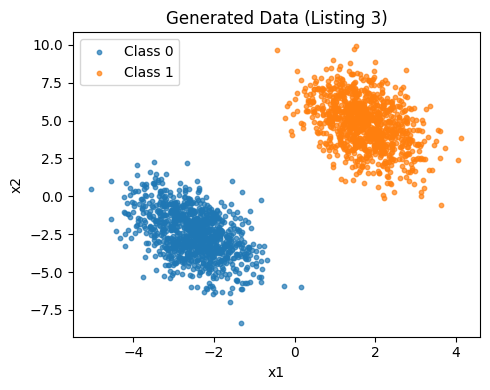

In [7]:
# Listing 3: Data generation for binary logistic regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

np.random.seed(0)
centers = [[-5, 0], [5, 1.5]]
X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = np.array([[0.5, 0.5], [-0.5, 1.5]])
X = np.dot(X, transformation)

# Add bias term by augmenting X with a column of ones
X_aug = np.c_[np.ones((X.shape[0], 1)), X]

# Quick scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(X[y==0, 0], X[y==0, 1], s=10, alpha=0.7, label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], s=10, alpha=0.7, label='Class 1')
plt.legend(); plt.title('Generated Data (Listing 3)'); plt.xlabel('x1'); plt.ylabel('x2'); plt.tight_layout(); plt.show()

In [8]:
# Helpers: sigmoid, loss, gradient, hessian

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Binary cross-entropy (log loss)
def log_loss(w, Xb, yb, reg=0.0):
    z = Xb @ w
    p = sigmoid(z)
    # Add small epsilon for numerical stability
    eps = 1e-12
    loss = -(yb * np.log(p + eps) + (1 - yb) * np.log(1 - p + eps)).mean()
    if reg > 0:
        loss += 0.5 * reg * np.sum(w[1:]**2)  # L2 on non-bias weights
    return loss

def gradient(w, Xb, yb, reg=0.0):
    p = sigmoid(Xb @ w)
    grad = (Xb.T @ (p - yb)) / Xb.shape[0]
    if reg > 0:
        g_reg = np.r_[0.0, reg * w[1:]]
        grad = grad + g_reg
    return grad

def hessian(w, Xb):
    p = sigmoid(Xb @ w)
    S = p * (1 - p)
    # X^T S X with S as diagonal weights
    return (Xb.T * S) @ Xb / Xb.shape[0]

In [9]:
# Batch Gradient Descent (20 iterations)
np.random.seed(1)
# Initialize small random weights to break symmetry; bias near 0
w_gd = np.random.randn(X_aug.shape[1]) * 0.01

eta = 0.5  # learning rate
iters = 20
loss_hist_gd = []

for t in range(iters):
    loss_hist_gd.append(log_loss(w_gd, X_aug, y))
    g = gradient(w_gd, X_aug, y)
    w_gd = w_gd - eta * g

print("GD final loss:", loss_hist_gd[-1])
print("GD weights:", w_gd)

GD final loss: 0.010862466896694496
GD weights: [-0.08483967  0.94061496  1.0922774 ]


In [10]:
# Newton's Method (20 iterations)
w_newton = np.zeros(X_aug.shape[1])  # start at zeros for clarity
iters = 20
loss_hist_nm = []

for t in range(iters):
    loss_hist_nm.append(log_loss(w_newton, X_aug, y))
    g = gradient(w_newton, X_aug, y)
    H = hessian(w_newton, X_aug)
    # Solve H * step = g  -> step = H^{-1} g
    step = np.linalg.solve(H + 1e-6*np.eye(H.shape[0]), g)
    w_newton = w_newton - step

print("Newton final loss:", loss_hist_nm[-1])
print("Newton weights:", w_newton)

Newton final loss: 1.6197861032953048e-07
Newton weights: [-1.77378791  7.55892569  3.34938858]


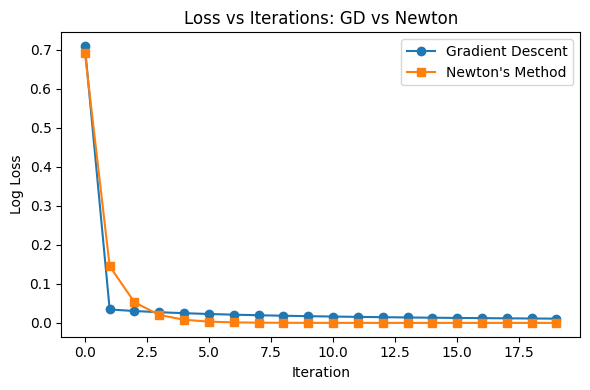

Comment:
Newton's method typically converges in fewer iterations because it uses second-order curvature (Hessian),
while GD uses only first-order information and depends on the learning rate. On well-behaved convex loss,
Newton often shows faster reduction in loss per iteration, though each iteration is more expensive.


In [11]:
# Plot loss vs iterations for GD and Newton
plt.figure(figsize=(6,4))
plt.plot(loss_hist_gd, label='Gradient Descent', marker='o')
plt.plot(loss_hist_nm, label="Newton's Method", marker='s')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Loss vs Iterations: GD vs Newton')
plt.legend(); plt.tight_layout(); plt.show()

print("Comment:")
print("Newton's method typically converges in fewer iterations because it uses second-order curvature (Hessian),")
print("while GD uses only first-order information and depends on the learning rate. On well-behaved convex loss,")
print("Newton often shows faster reduction in loss per iteration, though each iteration is more expensive.")

### Choosing the Number of Iterations
1. Use a convergence tolerance: stop when |L(t) − L(t−1)| < ε or ‖∇L(w)‖ < ε.
2. Use validation-based early stopping: monitor validation loss; stop after N epochs without improvement (patience).

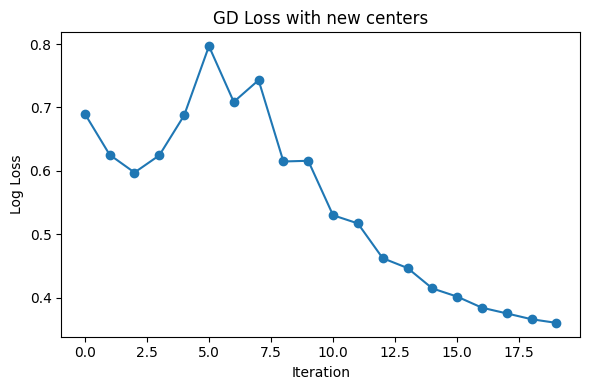

Convergence analysis:
Changing the centers shifts separability and the curvature of the loss surface.
If classes are more/less separable, the gradient magnitudes and Hessian conditioning change,
affecting the step efficiency. With the same learning rate, GD may converge faster or slower.


In [12]:
# Re-run GD with new centers [[2, 2], [5, 1.5]] and analyze convergence
np.random.seed(0)
centers = [[2, 2], [5, 1.5]]
X2, y2 = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = np.array([[0.5, 0.5], [-0.5, 1.5]])
X2 = np.dot(X2, transformation)
X2_aug = np.c_[np.ones((X2.shape[0], 1)), X2]

# GD again
w2 = np.random.randn(X2_aug.shape[1]) * 0.01
eta2 = 0.5
iters = 20
loss_hist_gd2 = []
for t in range(iters):
    loss_hist_gd2.append(log_loss(w2, X2_aug, y2))
    g2 = gradient(w2, X2_aug, y2)
    w2 = w2 - eta2 * g2

plt.figure(figsize=(6,4))
plt.plot(loss_hist_gd2, marker='o')
plt.xlabel('Iteration'); plt.ylabel('Log Loss'); plt.title('GD Loss with new centers')
plt.tight_layout(); plt.show()

print("Convergence analysis:")
print("Changing the centers shifts separability and the curvature of the loss surface.")
print("If classes are more/less separable, the gradient magnitudes and Hessian conditioning change,")
print("affecting the step efficiency. With the same learning rate, GD may converge faster or slower.")